<a href="https://colab.research.google.com/github/wfreinhart/sdmm-regression/blob/main/notebooks/figure8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load training data (just for convex hull)

In [ ]:
import pandas as pd

all_data = []
for keyword in ['random', 'kmeans']:
    data = pd.read_csv(f'polymers-umap-{keyword}.txt', header=None, names=['Sequence', 'Z0', 'Z1'])
    all_data.append(data)

orig_data = pd.concat(all_data)
print(len(orig_data))
orig_data

2038


,Sequence,Z0,Z1
0,AAAAAABBBBBBBBAAAAAA,5.671495,-0.404117
1,AAAABBAABABBBBBAAAAA,2.667750,-0.823994
2,AAAABBABBBBABABAAAAA,4.233039,-0.201995
3,AAAABBBAABABBBABAAAA,1.941323,0.588821
4,AAAABBBABABBABBAAAAA,0.554551,0.050845
...,...,...,...
1017,BBBBBBABAAAAAAAABAAA,5.918677,-3.045271
1018,BBBBBBBAAAAAABAAAAAA,-1.495865,-2.462502
1019,BBBBBBBAAAAABAAAAAAA,-1.076681,-2.863034
1020,BBBBBBBAABAAAAAAAAAA,4.458233,-4.845200


In [ ]:
try:
    import alphashape
except:
    !pip install alphashape
    import alphashape

from shapely.geometry import Polygon
import numpy as np

def make_alpha_hull(xy, alpha=1):
    alpha_shape = alphashape.alphashape(xy, alpha)
    xH, yH = alpha_shape.boundary.coords.xy
    return np.vstack([xH, yH]).T

orig_hull = make_alpha_hull(orig_data.loc[:, 'Z0':'Z1'])

     |████████████████████████████████| 646 kB 5.1 MB/s 
     |████████████████████████████████| 1.0 MB 46.6 MB/s 


# generate the data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive/Shareddrives/Polymers-Data'

Mounted at /content/drive


## predictions from GRU model

In [ ]:
gru_preds = pd.read_csv(os.path.join(drive_prefix, 'models', 'gru-folds-all-prediction.csv'), index_col=0)
gru_preds

,Sequence,Fold,Z0,Z1
0,BBBBBBBBAAAAAAAAAAAA,0,3.178819,-3.948265
1,BBBBBBBBAAAAAAAAAAAA,1,2.816892,-4.776179
2,BBBBBBBBAAAAAAAAAAAA,2,2.066317,-3.576468
3,BBBBBBBBAAAAAAAAAAAA,3,3.303682,-4.600911
4,BBBBBBBBAAAAAAAAAAAA,4,3.225766,-4.852340
...,...,...,...,...
630895,AAAAAABBBBBBBBAAAAAA,5,5.898496,-0.891070
630896,AAAAAABBBBBBBBAAAAAA,6,5.799550,-0.963563
630897,AAAAAABBBBBBBBAAAAAA,7,4.314689,-3.218789
630898,AAAAAABBBBBBBBAAAAAA,8,5.364920,-0.141351


## archetypes

In [ ]:
import json
import os

archetype_targets = {'liquid': np.array([20.471924,  2.369606]),
                     'membrane': np.array([1.214188, 9.048346]),
                     'spherical micelle': np.array([ 2.774236, -4.223681]),
                     'string': np.array([-4.319901,  7.762145]),
                     'vesicle': np.array([ 6.136077, 10.73103 ]),
                     'wormlike micelle': np.array([-4.627726,  0.183026]),
                     }

targets = [v.tolist() for k, v in archetype_targets.items()]
print(json.dumps(targets))

key_dir = 'gru-cv-archetypes-v2'

with open(os.path.join(os.path.join(drive_prefix, 'trajectories', key_dir, f'sequences-{key_dir}.txt')), 'r') as fid:
    sequences = [it.strip() for it in fid.readlines()]
print(sequences)

seq_preds = [gru_preds.loc[gru_preds['Sequence'] == seq, 'Z0':'Z1'].values for seq in sequences]

mu = np.mean(seq_preds, axis=1)
sigma = np.std(seq_preds, axis=1)

target_ids = np.hstack([np.ones(5)*i for i in range(len(targets))]).astype(int)

pred_data = pd.DataFrame({'Sequence': sequences,
                          'Z0_mu': mu[:, 0], 'Z1_mu': mu[:, 1],
                          'Z0_sigma': sigma[:, 0], 'Z1_sigma': sigma[:, 1],
                          'Target_ID': target_ids,
                          })
print(pred_data)

design_data = pd.read_csv(os.path.join(drive_prefix, 'trajectories', key_dir, 'embeddings.csv'), index_col=0)
design_data = design_data.loc[design_data['Frame'] == 4, 'Sequence':'Z1']

design_data = pd.concat([design_data.loc[design_data['Sequence'] == seq] for seq in sequences])

target_ids = np.hstack([np.ones(5*5)*i for i in range(len(targets))]).astype(int)
design_data['Target_ID'] = target_ids

design_data

# {targets: <list of lists>,
#  results: <list of dicts>}

# for each result:
#   * sequence
#   * target ID
#   * prediction
#   * MD result

[[20.471924, 2.369606], [1.214188, 9.048346], [2.774236, -4.223681], [-4.319901, 7.762145], [6.136077, 10.73103], [-4.627726, 0.183026]]
['BAAABABAABBAABAABABA', 'ABABAABAABBAABABAABA', 'BAABAABABABAABAABABA', 'BAAABAABABBAABAABABA', 'ABABAABAABABABABAABA', 'ABAAABBAAAABABBBBAAA', 'BABBAAABAAABABBAABAA', 'ABBAAAABAAAABBBBBAAA', 'ABBAAAABAAAABBBBABAA', 'ABBBAABAAABAAABBBAAA', 'BBBABBABAABBAAAAAAAA', 'BABBBBBABAABAAAAAAAA', 'BBABBBABAABBAAAAAAAA', 'BBBABBBABAABAAAAAAAA', 'BABBBBABAABBAAAAAAAA', 'ABBAABBAAAAABABBBAAA', 'ABABBABAAAAABBBABAAA', 'ABABBABAAAAABBABBAAA', 'ABBAABBAAAAABBBABAAA', 'AABBBABAAAAABBABBAAA', 'BBBAAAABAABAABAABBAA', 'BBBAAABAABAAABBAABAA', 'BBBAAAABAABAABBAABAA', 'BBABAAABAABAABAABBAA', 'BBBAAABAABAAABABABAA', 'BAABBBABAAAABBBAAAAA', 'BAABBBBAAAABABBAAAAA', 'BAABBBABAAABABBAAAAA', 'BAABBABBAAAABBBAAAAA', 'ABBBAABBAAAABBBAAAAA']
                Sequence      Z0_mu     Z1_mu  Z0_sigma  Z1_sigma  Target_ID
0   BAAABABAABBAABAABABA  20.333759  2.248004  0.339549  0.127747

,Sequence,Z0,Z1,Target_ID
329,BAAABABAABBAABAABABA,20.407690,2.235253,0
334,BAAABABAABBAABAABABA,20.486546,2.619609,0
339,BAAABABAABBAABAABABA,20.328863,1.951083,0
344,BAAABABAABBAABAABABA,20.117914,1.948951,0
349,BAAABABAABBAABAABABA,20.383142,2.698474,0
...,...,...,...,...
279,ABBBAABBAAAABBBAAAAA,-4.101957,0.206591,5
284,ABBBAABBAAAABBBAAAAA,-3.829140,-0.317352,5
289,ABBBAABBAAAABBBAAAAA,-4.050618,0.234654,5
294,ABBBAABBAAAABBBAAAAA,-4.526780,0.381217,5


In [ ]:
pred_data.to_csv('gru_archetypes_preds.csv')
design_data.to_csv('gru_archetypes_md.csv')

## kmeans

In [ ]:
import json
import os


n_seqs = 5
n_folds = 10
n_reps = 5

for key in ['archetypes', 'kmeans']:

    if key == 'kmeans':
        kmeans_targets = np.array( [[-1.1130867,   0.30891064],
                                    [10.66711953,  4.68760725],
                                    [ 5.2479162,   2.83027809],
                                    [ 3.37652963, -1.82501614],
                                    [16.5731166,   3.20359482],
                                    [-0.83194547,  4.98672806],
                                    [ 4.73299573,  8.12242395],
                                    [10.38375456, -0.96907237]] )

        targets = [v.tolist() for v in kmeans_targets]

    elif key == 'archetypes':
        archetype_targets = {'liquid': np.array([20.471924,  2.369606]),
                'membrane': np.array([1.214188, 9.048346]),
                'spherical micelle': np.array([ 2.774236, -4.223681]),
                'string': np.array([-4.319901,  7.762145]),
                'vesicle': np.array([ 6.136077, 10.73103 ]),
                'wormlike micelle': np.array([-4.627726,  0.183026]),
                }

        targets = [v.tolist() for k, v in archetype_targets.items()]

    print(json.dumps(targets))
    targets = np.array(targets)

    key_dir = f'gru-cv-{key}-v2'

    with open(os.path.join(os.path.join(drive_prefix, 'trajectories', key_dir, f'sequences-{key_dir}.txt')), 'r') as fid:
        sequences = [it.strip() for it in fid.readlines()]
    print(sequences)

    seq_preds = [gru_preds.loc[gru_preds['Sequence'] == seq, 'Z0':'Z1'].values for seq in sequences]

    target_ids = np.hstack([np.ones(n_seqs*n_folds)*i for i in range(len(targets))]).astype(int)
    fold_ids = np.hstack([np.arange(n_folds) for _ in range(len(targets)*n_seqs)])

    pred_data = pd.DataFrame({'Sequence': np.hstack([[it for _ in range(n_folds)] for it in sequences]),
                            'Z0': np.vstack(seq_preds)[:, 0],
                            'Z1': np.vstack(seq_preds)[:, 1],
                            'Target_ID': target_ids,
                            'Fold_ID': fold_ids,
                            })
    # print(pred_data)

    design_data = pd.read_csv(os.path.join(drive_prefix, 'trajectories', key_dir, 'embeddings.csv'), index_col=0)
    design_data = design_data.loc[design_data['Frame'] == 4, 'Sequence':'Z1']

    design_data = pd.concat([design_data.loc[design_data['Sequence'] == seq] for seq in sequences])

    target_ids = np.hstack([np.ones(n_seqs*n_reps)*i for i in range(len(targets))]).astype(int)
    design_data['Target_ID'] = target_ids

    design_data['Target_Z0'] = targets[target_ids][:, 0]
    design_data['Target_Z1'] = targets[target_ids][:, 1]

    # design_data
    pred_data.to_csv(f'gru_{key}_preds.csv')
    design_data.to_csv(f'gru_{key}_md.csv')

[[20.471924, 2.369606], [1.214188, 9.048346], [2.774236, -4.223681], [-4.319901, 7.762145], [6.136077, 10.73103], [-4.627726, 0.183026]]
['BAAABABAABBAABAABABA', 'ABABAABAABBAABABAABA', 'BAABAABABABAABAABABA', 'BAAABAABABBAABAABABA', 'ABABAABAABABABABAABA', 'ABAAABBAAAABABBBBAAA', 'BABBAAABAAABABBAABAA', 'ABBAAAABAAAABBBBBAAA', 'ABBAAAABAAAABBBBABAA', 'ABBBAABAAABAAABBBAAA', 'BBBABBABAABBAAAAAAAA', 'BABBBBBABAABAAAAAAAA', 'BBABBBABAABBAAAAAAAA', 'BBBABBBABAABAAAAAAAA', 'BABBBBABAABBAAAAAAAA', 'ABBAABBAAAAABABBBAAA', 'ABABBABAAAAABBBABAAA', 'ABABBABAAAAABBABBAAA', 'ABBAABBAAAAABBBABAAA', 'AABBBABAAAAABBABBAAA', 'BBBAAAABAABAABAABBAA', 'BBBAAABAABAAABBAABAA', 'BBBAAAABAABAABBAABAA', 'BBABAAABAABAABAABBAA', 'BBBAAABAABAAABABABAA', 'BAABBBABAAAABBBAAAAA', 'BAABBBBAAAABABBAAAAA', 'BAABBBABAAABABBAAAAA', 'BAABBABBAAAABBBAAAAA', 'ABBBAABBAAAABBBAAAAA']
[[-1.1130867, 0.30891064], [10.66711953, 4.68760725], [5.2479162, 2.83027809], [3.37652963, -1.82501614], [16.5731166, 3.20359482], [-0.831945

In [ ]:
pred_data.to_csv('gru_kmeans_preds.csv')
design_data.to_csv('gru_kmeans_md.csv')

# create the charts

In [ ]:
import matplotlib
import matplotlib.font_manager as font_manager
sc = 1.5
matplotlib.rcParams['font.family'] = 'Open Sans'  # the font name
matplotlib.rcParams['font.size'] = 9*sc           # the font size
font_manager._rebuild()  # this is a hack to fix something in Google Colab

In [ ]:
# the order in the original 2021 paper:
# 0       1         2                  3       4                  5
# string, membrane, vesicle,           liquid, spherical micelle, wormlike micelle
# liquid, membrane, spherical micelle, string, vesicle,           wormlike micelle
# will use it like: arch_order[target_id]
# arch_order = [liquid, membrane, spherical micelle, string, vesicle, wormlike micelle]
arch_order = [3, 1, 4, 0, 2, 5]

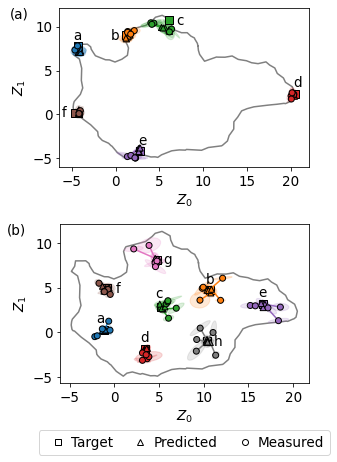

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import patches

def add_cov_ellipse(this_d, ax, color, alpha=0.5, mag=5.99):    

    cov = np.cov(this_d.values.T)
    vals, vecs = np.linalg.eig(cov)
    mu = np.mean(this_d.values, axis=0)
    theta = np.arctan(vecs[1, np.argmax(vals)] / vecs[0, np.argmax(vals)]) * 180 / np.pi

    ue = patches.Ellipse(mu, np.sqrt(mag*np.max(vals)), np.sqrt(mag*np.min(vals)),
                         angle=theta, alpha=0.167, color=color)
    ax.add_patch(ue)

    return 

plot_replicas = False

fig, axes = plt.subplots(2, 1, figsize=(3.54*sc, 3.54*sc*1.25))

letters = 'abcdefghijklmnopqrstuvwxyz'   

for k_idx, key in enumerate(['archetypes', 'kmeans']):

    pred_data = pd.read_csv(f'gru_{key}_preds.csv', index_col=0)
    design_data = pd.read_csv(f'gru_{key}_md.csv', index_col=0)

    ax = axes[k_idx]

    if key == 'kmeans':
        h_offs = [-0.5, 0.0, -0.25, 0.0, 0.0, 1.25, 1.25, 1.25]
        v_offs = [0.0, 0.0, 0.25, 0.0, 0.0, -1.25, -1.25, -1.25]
    else:
        h_offs = [0.25, -1.25, 0.25, 0, 1.25, -1.25]
        v_offs = [0,    -1.25, 0,    0, -1.25, -1.25]

    # plot the alpha shape
    ax.plot(*orig_hull.T, '-', color=np.ones(3)*0.5, zorder=-1)

    # plot the targets
    u, idx = np.unique(design_data['Target_ID'].values, return_index=True)
    targets = design_data.iloc[idx, :].loc[:, ['Target_Z0', 'Target_Z1']].values
    # make the order the same as Table 1 in 2021 paper
    if key == 'archetypes':
        u = [arch_order[it] for it in u]
    ax.scatter(*np.array(targets).T, c=u,
               facecolor='none', edgecolor='k', marker='s',
               s=64, cmap='tab10', vmin=0, vmax=9, zorder=3)

    # plot the prediction covariance and averages
    u, idx = np.unique(design_data['Sequence'].values, return_index=True)
    o = np.argsort(idx)
    seq_idx = idx[o]
    seq_u = u[o]
    loc_preds = np.ones([len(seq_u)*3, 3]) * np.nan

    markers = ['^', 'o']
    is_labeled = np.zeros(len(targets), dtype=bool)
    for k, this_data in enumerate([pred_data, design_data]):
        for i, seq in enumerate(seq_u):
            these_preds = this_data.loc[this_data['Sequence'] == seq, ['Z0', 'Z1', 'Target_ID']]
            target_id = these_preds['Target_ID'].unique()
            if len(target_id) != 1:
                raise ValueError('Expected ONE unique target_id')
            else:
                target_id = target_id[0]

            # make the order the same as Table 1 in 2021 paper
            if key == 'archetypes':
                target_id = arch_order[target_id]
            
            # create the covariance ellipse
            add_cov_ellipse(these_preds.loc[:, 'Z0':'Z1'], ax, cm.tab10(target_id))

            # append this result to the line chart
            loc_preds[(i*3)+k, :] = these_preds.values.mean(axis=0)
            if k == 0:
                loc_preds[(i*3)+2, 2] = these_preds.values.mean(axis=0)[2]
            
            # make the order the same as Table 1 in 2021 paper
            if key == 'archetypes':
                loc_preds[(i*3)+k, 2] = target_id
                loc_preds[(i*3)+2, 2] = target_id
            
            # plot all the individual replicas
            if plot_replicas:
                ax.scatter(these_preds['Z0'].values, these_preds['Z1'].values,
                        marker='o', c=np.ones(these_preds.shape[0])*target_id,
                        vmin=0, vmax=9, cmap='tab10', s=1, alpha=1)

            # label the targets
            if not is_labeled[target_id]:
                is_labeled[target_id] = True
                if key == 'archetypes':
                    letter_id = arch_order[target_id]
                else:
                    letter_id = target_id
                ax.text(targets[target_id, 0]+h_offs[target_id],
                        targets[target_id, 1]+0.75+v_offs[target_id],
                        letters[letter_id], ha='center')

        # plot the prediction (^) or observation (o) symbols
        ax.scatter(*loc_preds[k::3, :2].T, c=loc_preds[k::3, 2],
                vmin=0, vmax=9, cmap='tab10',
                marker=markers[k], edgecolor='k', zorder=10+k, alpha=1)

    # plot the lines separating predictions (^) and observations (o)
    for t_id in np.unique(loc_preds[:, 2]):
        this_idx = loc_preds[:, 2] == t_id
        ax.plot(*loc_preds[this_idx, :2].T, color=cm.tab10(t_id/10),
                linestyle='-', marker='', zorder=5, alpha=1)

    ax.text(-12, 11, f'({letters[k_idx]})')
    ax.set_aspect('equal')
    ax.set_xlabel('$Z_0$')
    ax.set_ylabel('$Z_1$')

ax.plot(np.nan, np.nan, 'ks', markerfacecolor='none', label='Target')
ax.plot(np.nan, np.nan, 'k^', markerfacecolor='none', label='Predicted')
ax.plot(np.nan, np.nan, 'ko', markerfacecolor='none', label='Measured')
ax.legend(ncol=3, numpoints=1, handletextpad=0, columnspacing=1, loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.tight_layout()

In [ ]:
fig.savefig('fig9.pdf')